# Quad modelling notebook

With this notebook, we provide an example of how to model a quadrupoly lensed quasar lens with a host galaxy and a lens galaxy component. The example is highly simplified and as we choose the same input model, a "perfect" reconstruction can be expected. Convergence in the PSO and MCMC chain is not guaranteed and this example provides a small run for illustration purpose.

We recommend to first go through the starting guide notebook, where the building blocks of *lenstronomy* are explained in detail.

In this notebook, we first create a mock image of a quadrupoly lensed quasar and then apply a PSO and an MCMC chain to recover the input lens parameters.

*lenstronomy* comes with a set of neat features that facilitate the modelling of quad lenses. This notebook introduces those features and how to use them.

In [1]:
# some python imports
__author__ = 'sibirrer'
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

import lenstronomy.Util.simulation_util as sim_util
import lenstronomy.Util.image_util as image_util
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.Sampling.parameters import Param
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF


## creating a mock image of a quad
We follow closely the starting guide in how we create a mock image with noise properties. In this example we use an elliptical power-law convergence profile with external shear as the lens model, two different Sersic profiles as the light components of the deflector and the quasar host galaxy and a HST-like resolution of the image.

/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in log10


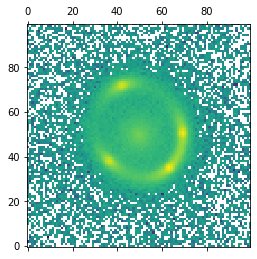

In [2]:

# data specifics
background_rms = .5  # background noise per pixel
exp_time = 100  # exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
numPix = 100  # cutout pixel size
deltaPix = 0.05  # pixel size in arcsec (area per pixel = deltaPix**2)
fwhm = 0.1  # full width half max of PSF

# PSF specification

kwargs_data = sim_util.data_configure_simple(numPix, deltaPix, exp_time, background_rms)
data_class = ImageData(**kwargs_data)
kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': fwhm, 'pixel_size': deltaPix, 'truncation': 5}
psf_class = PSF(**kwargs_psf)

lens_model_list = ['SPEP', 'SHEAR_GAMMA_PSI']
kwargs_shear = {'gamma_ext': 0.02, 'psi_ext': -0.1}  # gamma_ext: shear strength, psi_ext: shear angel (in radian)
kwargs_spemd = {'theta_E': 1., 'gamma': 1.96, 'center_x': 0, 'center_y': 0, 'e1': 0.05, 'e2': 0.05}
kwargs_lens = [kwargs_spemd, kwargs_shear]
lens_model_class = LensModel(lens_model_list=lens_model_list)

# list of light profiles (for lens and source)
# 'SERSIC': spherical Sersic profile
lens_light_model_list = ['SERSIC']
kwargs_sersic = {'amp': 400, 'R_sersic': 1., 'n_sersic': 2, 'center_x': 0, 'center_y': 0}
kwargs_lens_light = [kwargs_sersic]
lens_light_model_class = LightModel(light_model_list=lens_light_model_list)
# 'SERSIC_ELLIPSE': elliptical Sersic profile

source_model_list = ['SERSIC_ELLIPSE']
ra_source, dec_source = 0, 0.1
kwargs_sersic_ellipse = {'amp': 4000., 'R_sersic': .1, 'n_sersic': 3, 'center_x': ra_source,
                         'center_y': dec_source, 'e1': -0.1, 'e2': 0.01}
kwargs_source = [kwargs_sersic_ellipse]
source_model_class = LightModel(light_model_list=source_model_list)

lensEquationSolver = LensEquationSolver(lens_model_class)
x_image, y_image = lensEquationSolver.findBrightImage(ra_source, dec_source, kwargs_lens, numImages=4,
                                                      min_distance=deltaPix, search_window=numPix * deltaPix)
# compute lensing magnification at image positions
mag = lens_model_class.magnification(x_image, y_image, kwargs=kwargs_lens)
mag = np.abs(mag)  # ignore the sign of the magnification

# perturb observed magnification due to e.g. micro-lensing
mag_pert = np.random.normal(mag, 0.5, len(mag))
point_amp = mag_pert * 100  # multiply by intrinsic quasar brightness (in counts/s)
kwargs_ps = [{'ra_image': x_image, 'dec_image': y_image,
                           'point_amp': point_amp}]  # quasar point source position in the source plane and intrinsic brightness

# note: the relative magnification of point sources is not used as constraints in the fitting in the default settings of lenstronomy.
# you can set this constraint with the keyword 'fixed_magnification_list' (see next block). The images are treated otherwise as separate linear amplitudes that are constraint independently of each other.
point_source_list = ['LENSED_POSITION']
point_source_class = PointSource(point_source_type_list=point_source_list, fixed_magnification_list=[False])
kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}
imageModel = ImageModel(data_class, psf_class, lens_model_class, source_model_class,
                                lens_light_model_class,
                                point_source_class, kwargs_numerics=kwargs_numerics)
image_sim = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light, kwargs_ps)
poisson = image_util.add_poisson(image_sim, exp_time=exp_time)
bkg = image_util.add_background(image_sim, sigma_bkd=background_rms)
image_sim = image_sim + bkg + poisson

kwargs_data['image_data'] = image_sim
data_class.update_data(image_sim)

plt.matshow(np.log10(image_sim), origin='lower')
plt.show()

## Setup of the modelling

*lenstronomy* comes with some neat features that facilitate the modeling of quadrupoly lensed quasars. Among them are:

- one can couple different parameters together. E.g. the center of the source surface brightness of the host galaxy to the position of the quasar in the source plane. The keyword 'fix_to_point_source_list' can be set to 'True' for each individual index of the source surface brightness profile.

- The image positions of the quasar can be used as constraints on the lens model. Rather then having all lens model parameters as free parameters and solve for the image positions of the quasar, the image positions are treated as free parameters and part of the lens model parameters will be infered in post-processing by a non-linear solver. This option makes convergence in the lens model much faster. The option is set with the keyword 'solver'. There are two options available:
   - 'PROFILE': This solver inferes the center, ellipticities and Einstein radius of the first lens model by the best solution in mapping the four image positions to the same source plane position. This solver may not always find a precise solution.
   - 'PROFILE_SHEAR': This solver, takes in addition to 'PROFILE' also the shear angle (must be specified as the second lens model) to be solved in the demand of mapping the four point source images to the exact same source plane position.


In [3]:
kwargs_model = {'lens_model_list': lens_model_list,
                               'source_light_model_list': source_model_list,
                               'lens_light_model_list': lens_light_model_list,
                               'point_source_model_list': point_source_list,
                               'additional_images_list': [False],
                               'fixed_magnification_list': [False],  # list of bools (same length as point_source_type_list). If True, magnification ratio of point sources is fixed to the one given by the lens model 
                             }
kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}

num_source_model = len(source_model_list)

kwargs_constraints = {'joint_source_with_point_source': [[0, 0]],
                              'num_point_source_list': [4],
                              'solver_type': 'PROFILE_SHEAR',  # 'PROFILE', 'PROFILE_SHEAR', 'ELLIPSE', 'CENTER', 'NONE'
                              }

kwargs_likelihood = {'check_bounds': True,
                             'force_no_add_image': False,
                             'source_marg': False,
                             'position_uncertainty': 0.004,
                             'check_solver': False,
                             'solver_tolerance': 0.001,
                             'source_position_likelihood': True,
                             'position_uncertainty': 0.005
                             }

image_band = [kwargs_data, kwargs_psf, kwargs_numerics]
multi_band_list = [image_band]
kwargs_data_joint = {'multi_band_list': multi_band_list, 'multi_band_type': 'multi-linear'}

In [4]:
# initial guess of non-linear parameters, we chose different starting parameters than the truth #
kwargs_lens_init = [{'theta_E': 1.2, 'e1': 0, 'e2': 0, 'gamma': 2., 'center_x': 0., 'center_y': 0},
    {'gamma_ext': 0.01, 'psi_ext': 0.}]
kwargs_source_init = [{'R_sersic': 0.03, 'n_sersic': 1., 'e1': 0, 'e2': 0, 'center_x': 0, 'center_y': 0}]
kwargs_lens_light_init = [{'R_sersic': 0.1, 'n_sersic': 1, 'e1': 0, 'e2': 0, 'center_x': 0, 'center_y': 0}]
kwargs_ps_init = [{'ra_image': x_image+0.01, 'dec_image': y_image-0.01}]

# initial spread in parameter estimation #
kwargs_lens_sigma = [{'theta_E': 0.3, 'e1': 0.2, 'e2': 0.2, 'gamma': .2, 'center_x': 0.1, 'center_y': 0.1},
    {'gamma_ext': 0.1, 'psi_ext': np.pi}]
kwargs_source_sigma = [{'R_sersic': 0.1, 'n_sersic': .5, 'center_x': .1, 'center_y': 0.1, 'e1': 0.2, 'e2': 0.2}]
kwargs_lens_light_sigma = [{'R_sersic': 0.1, 'n_sersic': 0.2, 'e1': 0.1, 'e2': 0.1, 'center_x': .1, 'center_y': 0.1}]
kwargs_ps_sigma = [{'ra_image': [0.02] * 4, 'dec_image': [0.02] * 4}]

# hard bound lower limit in parameter space #
kwargs_lower_lens = [{'theta_E': 0, 'e1': -0.5, 'e2': -0.5, 'gamma': 1.5, 'center_x': -10., 'center_y': -10},
    {'gamma_ext': 0., 'psi_ext': -np.pi}]
kwargs_lower_source = [{'R_sersic': 0.001, 'n_sersic': .5, 'e1': -0.5, 'e2': -0.5, 'center_x': -10, 'center_y': -10}]
kwargs_lower_lens_light = [{'R_sersic': 0.001, 'n_sersic': 0.5, 'e1': -0.5, 'e2': -0.5, 'center_x': -10, 'center_y': -10}]
kwargs_lower_ps = [{'ra_image': -10 * np.ones_like(x_image), 'dec_image': -10 * np.ones_like(y_image)}]

# hard bound upper limit in parameter space #
kwargs_upper_lens = [{'theta_E': 10, 'e1': 0.5, 'e2': 0.5, 'gamma': 2.5, 'center_x': 10., 'center_y': 10},
    {'gamma_ext': 0.3, 'psi_ext': np.pi}]
kwargs_upper_source = [{'R_sersic': 10, 'n_sersic': 5., 'e1': 0.5, 'e2': 0.5, 'center_x': 10, 'center_y': 10}]
kwargs_upper_lens_light = [{'R_sersic': 10, 'n_sersic': 5., 'e1': 0.5, 'e2': 0.5, 'center_x': 10, 'center_y': 10}]
kwargs_upper_ps = [{'ra_image': 10 * np.ones_like(x_image), 'dec_image': 10 * np.ones_like(y_image)}]

lens_params = [kwargs_lens_init, kwargs_lens_sigma, [{}, {'ra_0': 0, 'dec_0': 0}], kwargs_lower_lens, kwargs_upper_lens]
source_params = [kwargs_source_init, kwargs_source_sigma, [{}], kwargs_lower_source, kwargs_upper_source]
lens_light_params = [kwargs_lens_light_init, kwargs_lens_light_sigma, [{}], kwargs_lower_lens_light, kwargs_upper_lens_light]
ps_params = [kwargs_ps_init, kwargs_ps_sigma, [{}], kwargs_lower_ps, kwargs_upper_ps]

kwargs_params = {'lens_model': lens_params,
                'source_model': source_params,
                'lens_light_model': lens_light_params,
                'point_source_model': ps_params}

from lenstronomy.Workflow.fitting_sequence import FittingSequence
fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params)

fitting_kwargs_list = [['PSO', {'sigma_scale': 1., 'n_particles': 100, 'n_iterations': 200}],
                       ['MCMC', {'n_burn': 10, 'n_run': 10, 'walkerRatio': 4, 'sigma_scale': .1}]
        ]

chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()

/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/scipy-1.1.0-py3.6-macosx-10.13-x86_64.egg/scipy/optimize/minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


Computing the PSO ...


/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/scipy-1.1.0-py3.6-macosx-10.13-x86_64.egg/scipy/optimize/minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
max iteration reached! stoping
-0.9860148499067023 reduced X^2 of best position
-4917.749063909678 logL
9975 effective number of data points
[{'theta_E': 0.9987283932289318, 'gamma': 1.9514592348593505, 'e1': 0.05027766100479991, 'e2': 0.0503498343798427, 'center_x': -0.00021626436569472494, 'center_y': -0.00034339741518237194}, {'gamma_ext': 0.020733750447979652, 'psi_ext': -0.06519302486038957, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 0.09893752312896609, 'n_sersic': 2.9640868180484525, 'e1': -0.09815388227340657, 'e2': 0.01061993057221126, 'center_x': -0.00011848165198082017, 'center_y': 0.09913364219532333}] source result
[{'amp': 1, 'R_sersic': 1.025247018728931, 'n_sersic': 2.027234885565945, 'center_x': -0.0013090091265870077, 'center_y': -0.00014515461049735808}] lens light result
[{'ra_image': array([-0.38537573,  0.67353165,  0.973213  , -0.65772809]), 'dec_image': array([ 1.10294034, -0

/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Computing the MCMC...
Number of walkers =  76
Burn-in iterations:  10
Sampling iterations: 10
18.731332778930664 time taken for MCMC sampling


-0.9835498127819355 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  0.9756867062696565
(19, ['gamma_lens0', 'gamma_ext_lens1', 'psi_ext_lens1', 'R_sersic_source_light0', 'n_sersic_source_light0', 'e1_source_light0', 'e2_source_light0', 'R_sersic_lens_light0', 'n_sersic_lens_light0', 'center_x_lens_light0', 'center_y_lens_light0', 'ra_image', 'ra_image', 'ra_image', 'ra_image', 'dec_image', 'dec_image', 'dec_image', 'dec_image'])


/Users/sibirrer/Software/lenstronomy/lenstronomy/Plots/model_band_plot.py:82: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',


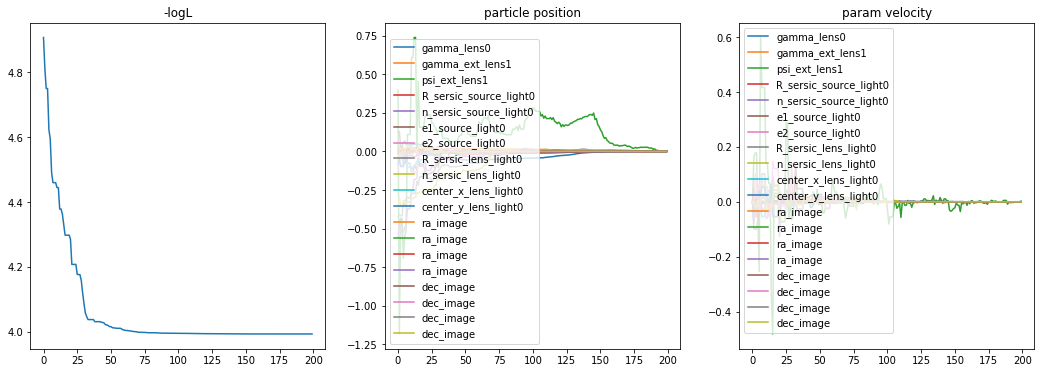

<Figure size 432x288 with 0 Axes>

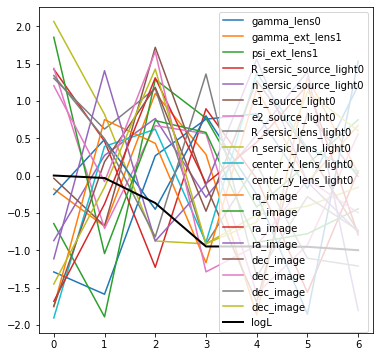

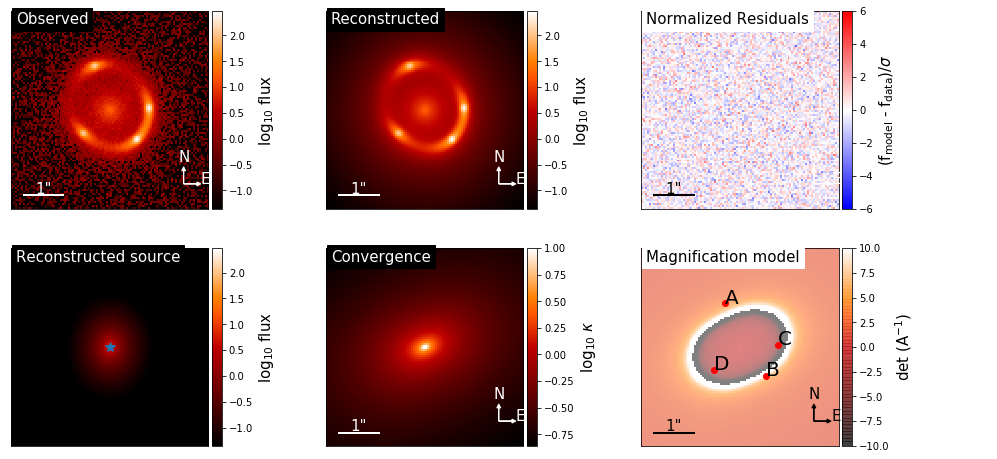

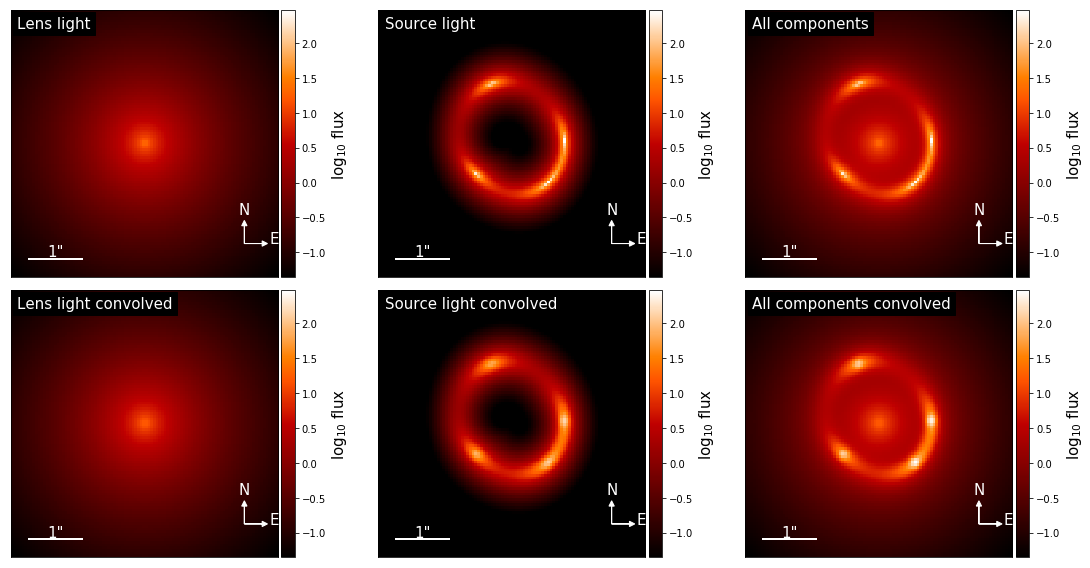

{'kwargs_lens': [{'theta_E': 0.9987283932289318, 'gamma': 1.9514592348593505, 'e1': 0.05027766100479991, 'e2': 0.0503498343798427, 'center_x': -0.00021626436569472494, 'center_y': -0.00034339741518237194}, {'gamma_ext': 0.020733750447979652, 'psi_ext': -0.06519302486038957, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': 4007.1681232015617, 'R_sersic': 0.09893752312896609, 'n_sersic': 2.9640868180484525, 'e1': -0.09815388227340657, 'e2': 0.01061993057221126, 'center_x': -0.00011848165198082017, 'center_y': 0.09913364219532333}], 'kwargs_lens_light': [{'amp': 385.3312168690134, 'R_sersic': 1.025247018728931, 'n_sersic': 2.027234885565945, 'center_x': -0.0013090091265870077, 'center_y': -0.00014515461049735808}], 'kwargs_ps': [{'ra_image': array([-0.38537573,  0.67353165,  0.973213  , -0.65772809]), 'dec_image': array([ 1.10294034, -0.7319278 ,  0.05368438, -0.58238002]), 'point_amp': array([370.59165521, 827.10941665, 559.05773878, 259.47463158])}], 'kwargs_special': {}, 'kwargs_exti

In [5]:
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.Plots import chain_plot

modelPlot = ModelPlot(multi_band_list, kwargs_model, kwargs_result, arrow_size=0.02, cmap_string="gist_heat")

param_class = fitting_seq.param_class
print(param_class.num_param())
#print(chain_list)

for i in range(len(chain_list)):
    chain_plot.plot_chain_list(chain_list, i)

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

modelPlot.data_plot(ax=axes[0,0])
modelPlot.model_plot(ax=axes[0,1])
modelPlot.normalized_residual_plot(ax=axes[0,2], v_min=-6, v_max=6)
modelPlot.source_plot(ax=axes[1, 0], deltaPix_source=0.01, numPix=100)
modelPlot.convergence_plot(ax=axes[1, 1], v_max=1)
modelPlot.magnification_plot(ax=axes[1, 2])
#f.tight_layout()
#f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
#plt.show()

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

modelPlot.decomposition_plot(ax=axes[0,0], text='Lens light', lens_light_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1,0], text='Lens light convolved', lens_light_add=True)
modelPlot.decomposition_plot(ax=axes[0,1], text='Source light', source_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1,1], text='Source light convolved', source_add=True)
modelPlot.decomposition_plot(ax=axes[0,2], text='All components', source_add=True, lens_light_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1,2], text='All components convolved', source_add=True, lens_light_add=True, point_source_add=True)
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()
print(kwargs_result)

number of non-linear parameters in the MCMC process:  19
parameters in order:  ['gamma_lens0', 'gamma_ext_lens1', 'psi_ext_lens1', 'R_sersic_source_light0', 'n_sersic_source_light0', 'e1_source_light0', 'e2_source_light0', 'R_sersic_lens_light0', 'n_sersic_lens_light0', 'center_x_lens_light0', 'center_y_lens_light0', 'ra_image', 'ra_image', 'ra_image', 'ra_image', 'dec_image', 'dec_image', 'dec_image', 'dec_image']
number of evaluations in the MCMC process:  760


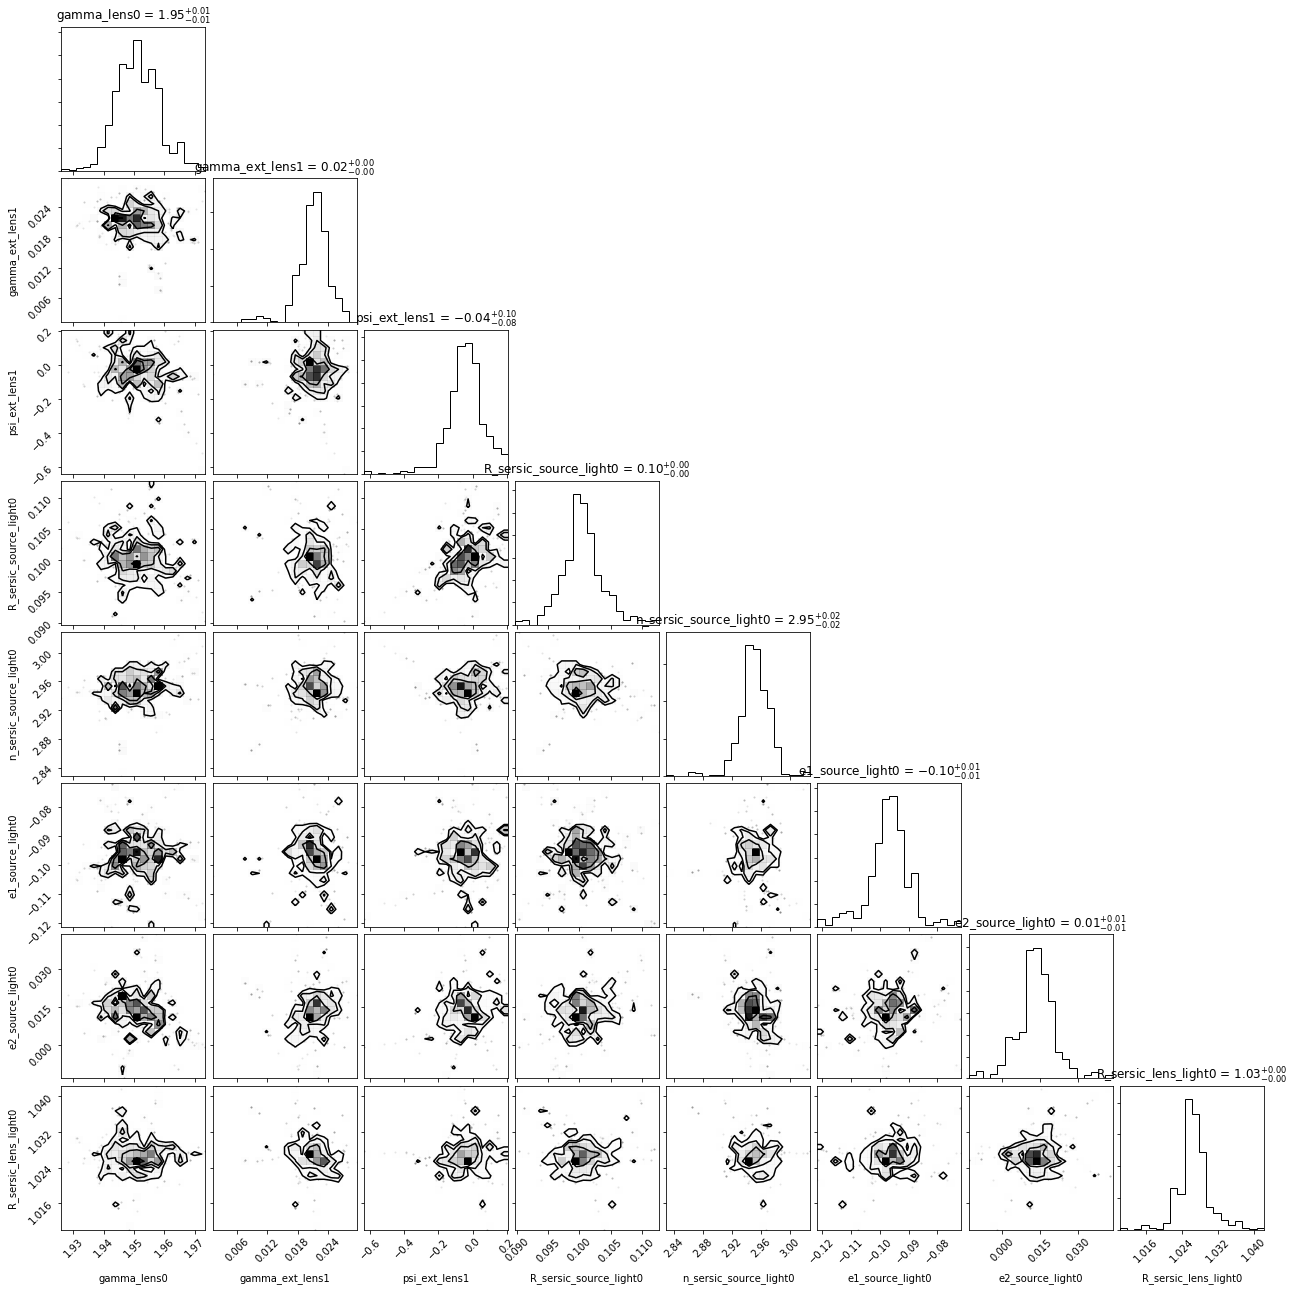

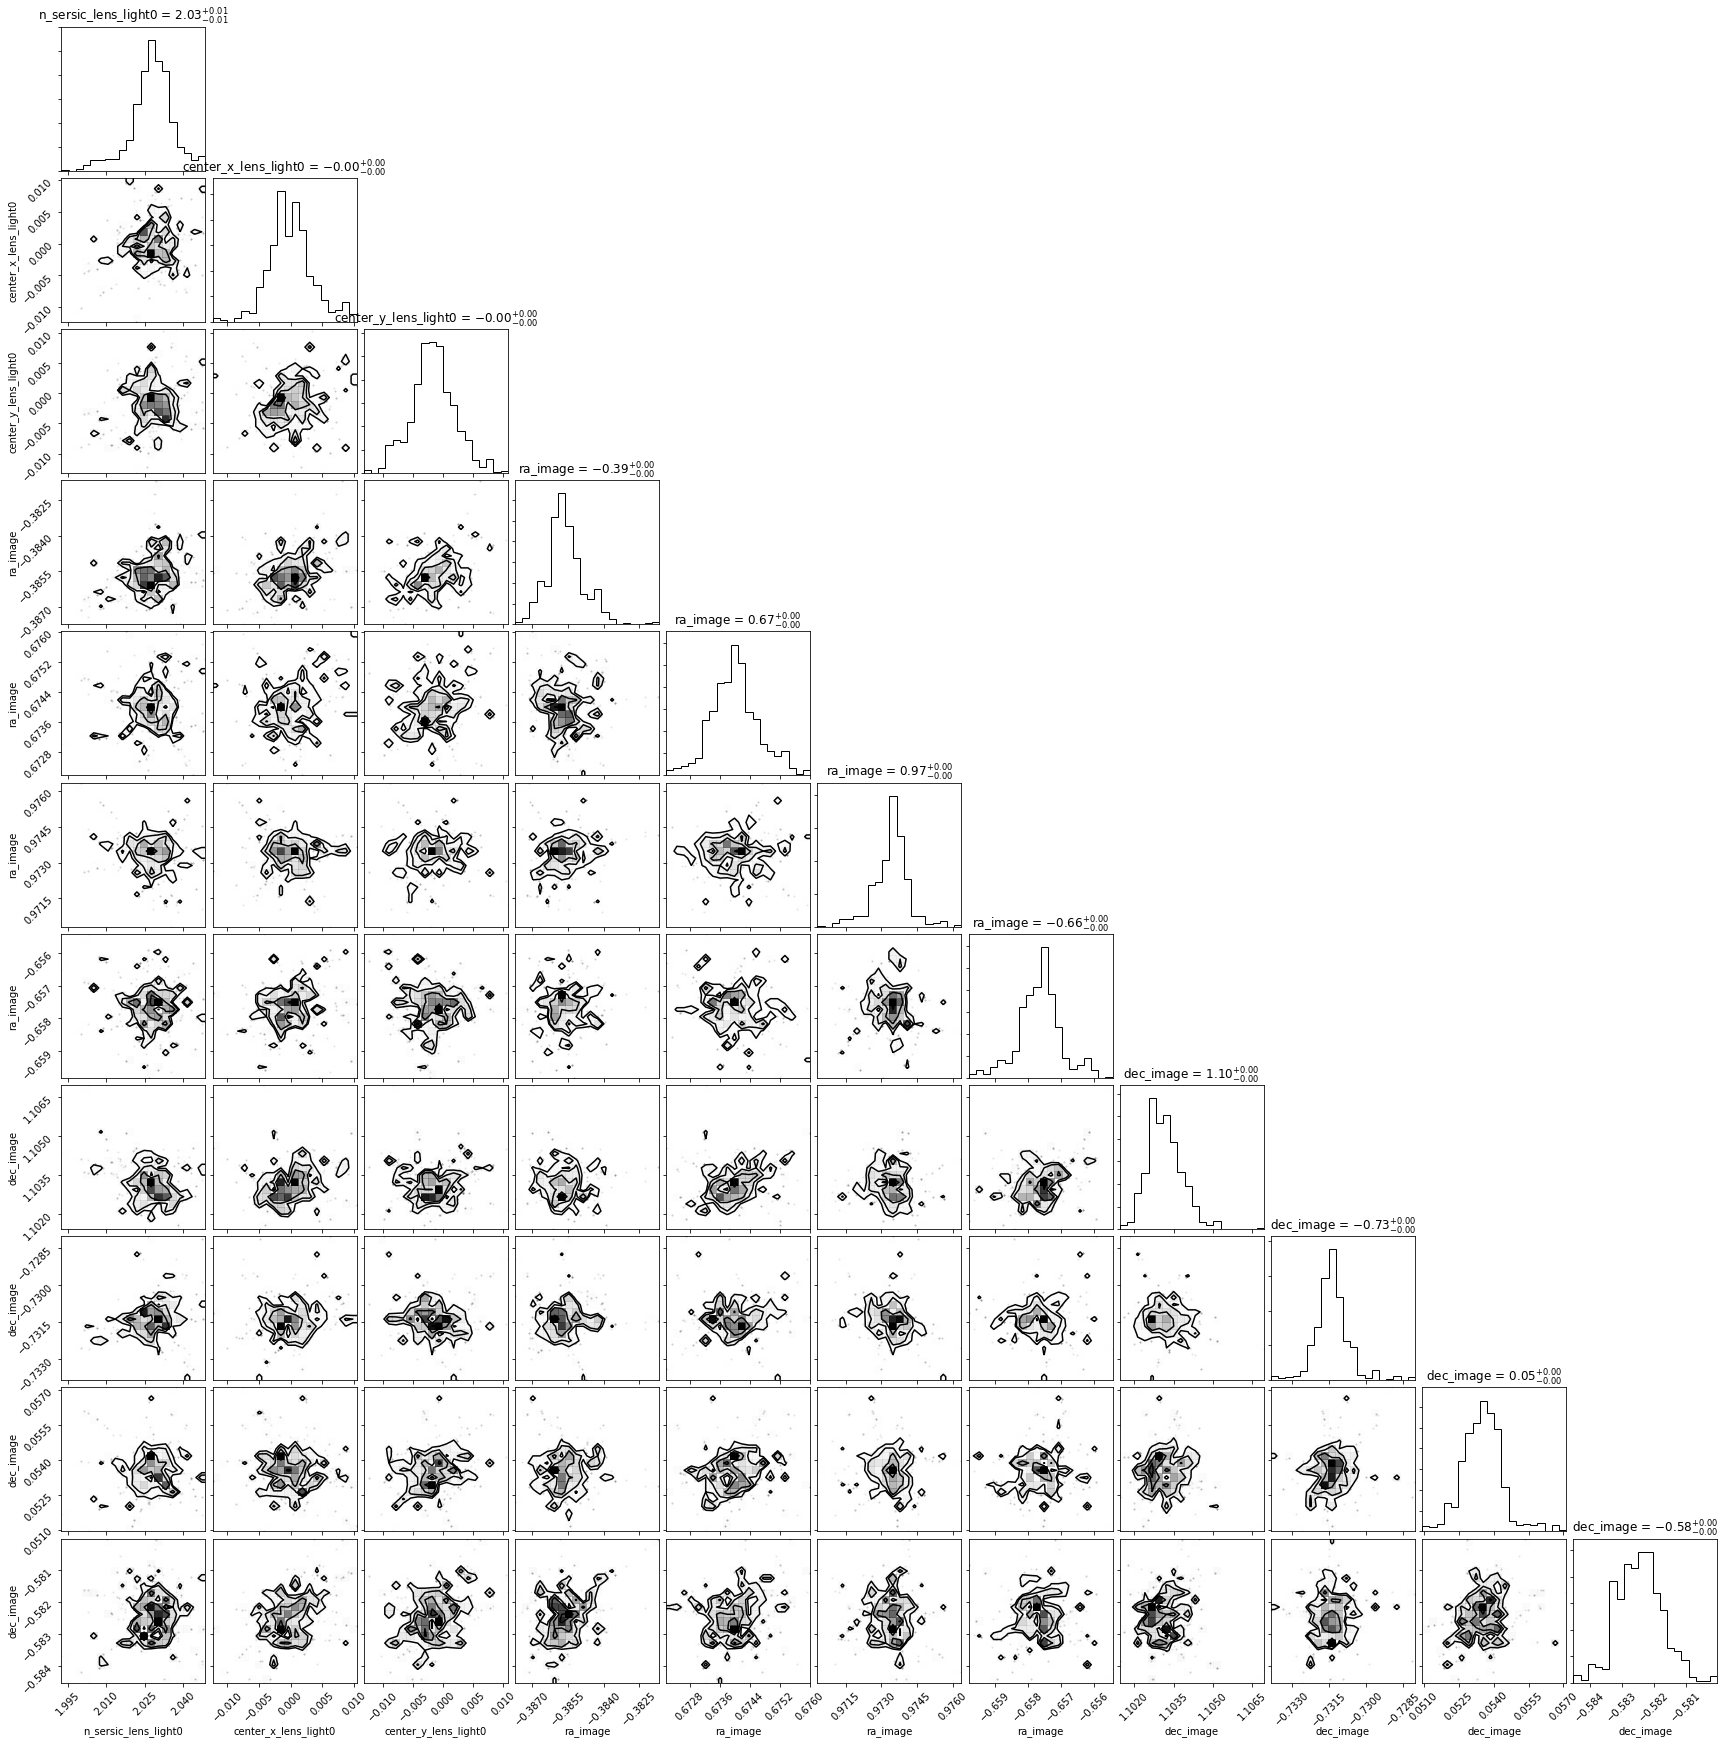

In [6]:

sampler_type, samples_mcmc, param_mcmc, dist_mcmc  = chain_list[1]
    
print("number of non-linear parameters in the MCMC process: ", len(param_mcmc))
print("parameters in order: ", param_mcmc)
print("number of evaluations in the MCMC process: ", np.shape(samples_mcmc)[0])
import corner

n, num_param = np.shape(samples_mcmc)
plot = corner.corner(samples_mcmc[:,:8], labels=param_mcmc[:8], show_titles=True)
plot = corner.corner(samples_mcmc[:,8:], labels=param_mcmc[8:], show_titles=True)